## Introduction

Galaxy clusters are the largest gravitationally bound structures in the Universe and
provide important insights into large-scale structure formation and the distribution
of dark matter. One of the key physical properties of a galaxy cluster is its **dynamical
mass**, which can be estimated using the motions of its member galaxies.

In this project, we analyze spectroscopic data obtained from the SDSS SkyServer to
identify a galaxy cluster and estimate its physical properties. Using redshift
measurements, we identify cluster members, convert redshifts to recession velocities,
and compute the **velocity dispersion** of the system. This quantity is crucial for
understanding the dynamical state of the cluster and forms the basis for estimating
its total mass.

The analysis makes use of standard Python libraries commonly employed in astronomical
data analysis. These include `numpy` for numerical calculations, `pandas` for handling
tabular SDSS data, and `matplotlib` for visualization of redshift and velocity
distributions.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G, c
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u

Before we begin calculations, we define key physical constants used throughout:

- $ H_0 $: Hubble constant, describes the expansion rate of the Universe.
- $c$ : Speed of light.
-  $G$: Gravitational constant.
- $q_0$ : Deceleration parameter, used for approximate co-moving distance calculations.

We will use **`astropy.constants`** to ensure unit consistency and precision.

In [2]:
# Constants:
# Cosmological constant H0 in SI units (s^-1)
H_0 = cosmo.H0.to(1 / u.s).value # Hubble constant in SI
c = c.to('m/s').value # Speed of light in m/s
G = G.to('m3 / (kg s2)').value # Gravitational constant in pc kg^-1 (m/s)^2
q0=-0.534  # Deceleration parameter (assumed from Planck fit keep it as it is)

In [3]:
import pandas as pd
from pathlib import Path

# Notebook ke folder ka path
base_dir = Path.cwd()

# CSV file (same folder me ho to sirf file name)
csv_file = base_dir / "Skyserver-SDSS.csv"

df = pd.read_csv(
    csv_file,
    header=0,
    comment="#"
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      139 non-null    int64  
 1   ra         139 non-null    float64
 2   dec        139 non-null    float64
 3   photoz     139 non-null    float64
 4   photozerr  139 non-null    float64
 5   specz      139 non-null    float64
 6   speczerr   139 non-null    float64
 7   proj_sep   139 non-null    float64
 8   umag       139 non-null    float64
 9   umagerr    139 non-null    float64
 10  gmag       139 non-null    float64
 11  gmagerr    139 non-null    float64
 12  rmag       139 non-null    float64
 13  rmagerr    139 non-null    float64
 14  obj_type   139 non-null    int64  
dtypes: float64(13), int64(2)
memory usage: 16.4 KB


## Data Description and Preprocessing

The dataset contains spectroscopic observations of galaxies obtained from the SDSS
SkyServer. Each galaxy is identified by a unique **object ID**, which corresponds to
a unique sky object.

Upon inspection, we find that multiple observations exist for the same object ID.
This indicates that some galaxies have been observed more than once. To ensure that
each physical object is treated consistently, the data must be grouped based on the
object ID before performing any statistical or physical analysis. This preprocessing
step ensures that each galaxy contributes appropriately to the final results.

In [4]:
# Calculating the average specz for each id:
averaged_df = df.groupby('objid').agg({'specz': 'mean','ra': 'first','dec': 'first','proj_sep': 'first',}).reset_index()
averaged_df.describe()['specz']

count    92.000000
mean      0.080838
std       0.008578
min       0.069976
25%       0.077224
50%       0.080961
75%       0.082797
max       0.150886
Name: specz, dtype: float64

## Identification of the Galaxy Cluster in Redshift Space

Galaxies belonging to the same cluster are expected to lie close to each other in
redshift space, as they are gravitationally bound and located at similar cosmological
distances. Therefore, the redshift distribution provides a powerful way to identify
cluster members.

To visualize this distribution, we plot a histogram of the redshift values. A prominent
peak in the histogram indicates the presence of a galaxy cluster, while galaxies far
from this peak are likely foreground or background objects.

To quantitatively define cluster membership, we compute the mean redshift $\bar{z}$
and the standard deviation $\sigma_z$ of the redshift distribution. A $3\sigma$ clipping
criterion is then applied, where galaxies lying more than three standard deviations
away from the mean redshift are rejected as non-members.

The $3\sigma$ limits used to identify cluster members are given by

$$
z_{\mathrm{min}} = \bar{z} - 3\sigma_z
$$

$$
z_{\mathrm{max}} = \bar{z} + 3\sigma_z
$$

Only galaxies with redshifts lying within these limits are retained for further analysis.

In [5]:
averaged_df['specz'].mean(),3*averaged_df['specz'].std(), averaged_df['specz'].mean()+3*averaged_df['specz'].std()

(np.float64(0.08083762565217394),
 0.0257328417489049,
 np.float64(0.10657046740107884))

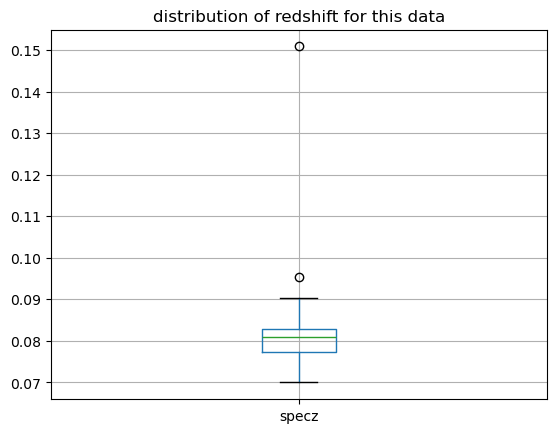

In [6]:
averaged_df.boxplot(column='specz')
plt.title("distribution of redshift for this data")
plt.show()

The most effective way to visualize the redshift distribution of the observed objects is
by using a histogram. A histogram clearly shows how the objects are distributed in redshift
space and allows us to identify where the majority of the galaxies are concentrated.

Since galaxies belonging to the same cluster are expected to have similar redshift values,
they will appear as a prominent peak in the histogram. This makes it easier to distinguish
the cluster population from foreground and background galaxies.

Therefore, plotting a histogram of redshift values is the best approach to visually identify
the cluster and to justify the application of a redshift cut based on statistical criteria
such as the $3\sigma$ limit.

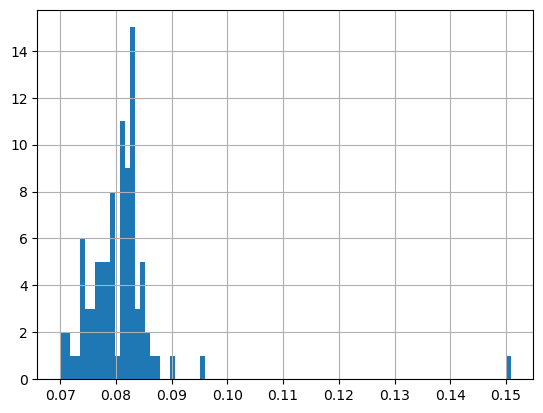

In [7]:
plt.hist(averaged_df['specz'],bins=90)
plt.grid()
plt.show()

After determining the mean redshift and the standard deviation of the redshift distribution,
we apply a $3\sigma$ cut to filter the data and identify probable cluster members.

All data points lying more than three standard deviations away from the mean redshift are
considered outliers and are removed from the dataset. This ensures that foreground and
background galaxies, which do not belong to the cluster, are excluded from the analysis.

Mathematically, the filtering criterion is defined as

$$
\bar{z} - 3\sigma_z \le z \le \bar{z} + 3\sigma_z
$$

Only galaxies with redshift values within this range are retained, while all galaxies with
redshifts outside these limits are rejected. This $3\sigma$ filtering provides a statistically
robust method to isolate the galaxy cluster population.

In [8]:
# Filtering the data based on specz values, used 3 sigma deviation from mean as upper limit.
filtered_df = averaged_df[(averaged_df['specz'] >= 0.06) & 
(averaged_df['specz'] <= averaged_df['specz'].mean()+3*averaged_df['specz'].std())]

filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 0 to 91
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   objid     91 non-null     int64  
 1   specz     91 non-null     float64
 2   ra        91 non-null     float64
 3   dec       91 non-null     float64
 4   proj_sep  91 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 4.3 KB


The expansion velocity corresponding to a given redshift can be obtained using the
non-relativistic relation between redshift and velocity, which is valid for small redshift
values:

$$
v = cz
$$

where $v$ is the recession (expansion) velocity, $c$ is the speed of light, and $z$ is the
redshift.

Using this relation, a new column named **velocity** is added to the dataset. This column
represents the expansion velocity of each galaxy corresponding to its measured redshift.
The velocity provides a physical interpretation of the redshift in terms of the cosmic
expansion and is useful for further dynamical analysis of the galaxy cluster.

In [9]:
filtered_df.loc[:,'velocity'] = filtered_df['specz'] * c
filtered_df.head(2)

/tmp/ipykernel_7797/87856802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:,'velocity'] = filtered_df['specz'] * c


,objid,specz,ra,dec,proj_sep,velocity
0,1237671768542478711,0.082457,257.82458,64.133257,8.347733,2.471993e+07
1,1237671768542478713,0.081218,257.83332,64.126043,8.011259,2.434867e+07


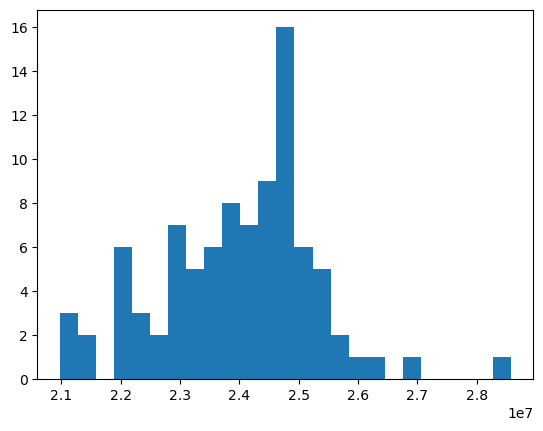

In [10]:
plt.hist(filtered_df['velocity'],bins=25)
plt.show()

To characterize the dynamical state of the galaxy cluster, we compute the **velocity
dispersion**, which measures how widely the galaxy velocities are spread around the mean
velocity of the system.

In astronomy, velocity dispersion is an important quantity because it reflects the depth
of the gravitational potential well of a system such as a galaxy cluster. A larger velocity
dispersion indicates stronger gravitational binding and can also suggest that some galaxies
may belong to an even larger structure, such as a supercluster.

The velocity dispersion is defined as the standard deviation of the galaxy velocities and
is given by

$$
\sigma_v = \sqrt{\frac{1}{N-1}\sum_{i=1}^{N}(v_i - \bar{v})^2}
$$

where $v_i$ is the velocity of the $i$-th galaxy, $\bar{v}$ is the mean velocity of the
sample, and $N$ is the total number of galaxies considered.

Using the velocities derived from the redshift measurements, the velocity dispersion
provides a quantitative measure of the internal motions of galaxies within the cluster.
A high velocity dispersion may indicate that some galaxies are part of a larger-scale
structure rather than being bound to a single relaxed cluster.


### Calculate Mean Redshift of the Cluster
We calculate the average redshift (`specz`) of galaxies that belong to a cluster. This gives us an estimate of the cluster's systemic redshift.

`cluster_redshift = filtered_df['specz'].mean()`

The velocity dispersion \( v \) of galaxies relative to the cluster mean redshift is computed using the relativistic Doppler formula:

$$
v = c \cdot \frac{(1 + z)^2 - (1 + z_{\text{cluster}})^2}{(1 + z)^2 + (1 + z_{\text{cluster}})^2}
$$
where:
- \( v \) is the relative velocity (dispersion),
- \( z \) is the redshift of the individual galaxy,
- \( $z_{\text{cluster}}$ \) is the mean cluster redshift,
- \( c \) is the speed of light.


In [11]:
# Mean Redshift:
cluster_redshift = filtered_df['specz'].mean()
# Converting redshift to velocity dispersion of individual galaxies within cluster:
filtered_df.loc[:,'dispersion'] = (((1 + filtered_df['specz'])**2 - (1 + cluster_redshift)**2)/((1 + filtered_df['specz'])**2 
+(1+cluster_redshift)**2)) * c

/tmp/ipykernel_7797/3089618654.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:,'dispersion'] = (((1 + filtered_df['specz'])**2 - (1 + cluster_redshift)**2)/((1 + filtered_df['specz'])**2


A quick way to obtain basic statistical information about a data column in pandas is by
using the `describe()` function. This function provides a concise summary of key statistics,
including the count, mean, standard deviation, minimum, maximum, and quartile values of the
data.

When applied to the **velocity** column, the `describe()` function is particularly useful
because it directly returns the **standard deviation**, which corresponds to the velocity
dispersion of the system. This allows us to quickly estimate the spread in galaxy velocities
without explicitly computing the dispersion using a separate formula.

Therefore, the `describe()` function serves as an efficient tool for obtaining a quick
statistical overview of the velocity distribution and for verifying the velocity dispersion
value derived through formal calculations.


In [12]:
filtered_df.describe()['dispersion']

count    9.100000e+01
mean    -2.449331e+03
std      1.218493e+06
min     -2.814231e+06
25%     -8.066068e+05
50%      2.371791e+05
75%      7.549776e+05
max      4.206137e+06
Name: dispersion, dtype: float64

In [13]:
disp = ( ((filtered_df['dispersion'])**2).mean() )**0.5
print(f"The value of the cluster redshift = {cluster_redshift:.4}")
print(f"The characteristic value of velocity dispersion of the cluster along the line of sight = {disp:.4} km/s.")

The value of the cluster redshift = 0.08007
The characteristic value of velocity dispersion of the cluster along the line of sight = 1.212e+06 km/s.


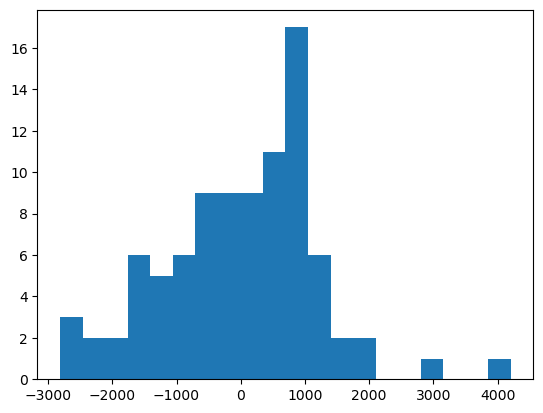

In [14]:
plt.hist(filtered_df['dispersion']/1000,bins=20)
plt.show()

In [15]:
df.describe()['proj_sep']

count    139.000000
mean       6.079801
std        2.517581
min        0.429175
25%        4.045745
50%        6.405518
75%        8.347733
max        9.844519
Name: proj_sep, dtype: float64

### Visualizing Angular Separation of Galaxies
We plot a histogram of the projected (angular) separation of galaxies from the cluster center. This helps us understand the spatial distribution of galaxies within the cluster field.

- The x-axis represents the angular separation (in arcminutes or degrees, depending on units).
- The y-axis shows the number of galaxies at each separation bin.


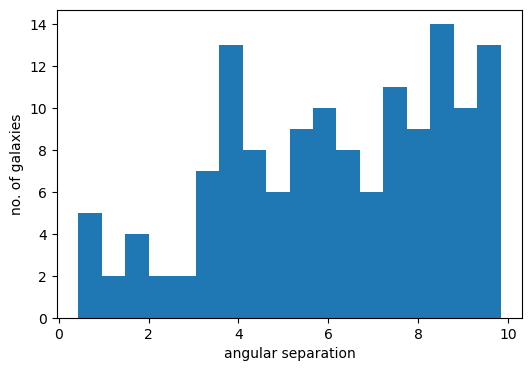

In [16]:
plt.figure(figsize=(6,4))
plt.hist(df['proj_sep'],bins=18)
plt.ylabel("no. of galaxies")
plt.xlabel("angular separation")
plt.show()

### Determining size and mass of the cluster:
### Estimating Physical Diameter of the Cluster
We now estimate the **physical diameter** of the galaxy cluster using cosmological parameters.

- `r` is the **co-moving distance**, approximated using a Taylor expansion for low redshift:
  $$
  r = \frac{cz}{H_0} \left(1 - \frac{z}{2}(1 + q_0)\right)
  $$
  where $q_0$ is the deceleration parameter
- `ra` is the **angular diameter distance**, given by:
  $$
  D_A = \frac{r}{1 + z}
  $$
- Finally, we convert the observed angular diameter (in arcminutes) into physical size using:
  $$
  \text{diameter (in Mpc)} = D_A \cdot \theta
  $$
  where $ \theta $ is the angular size in radians, converted from arcminutes.

> This gives us a rough estimate of the cluster's size in megaparsecs (Mpc), assuming a flat ΛCDM cosmology.


In [17]:
r=c*(cluster_redshift/H_0)*(1-(cluster_redshift/2)*(1+q0))
ra=r/(1+cluster_redshift)
diameter=ra*((9.415/60)*(np.pi/180))/(3.086e22)
diameter #in Mpc

np.float64(0.8827105529067586)

### Calculating the Dynamical Mass of the Cluster
We now estimate the **dynamical mass** of the galaxy cluster using the virial theorem:

$$
M_{\text{dyn}} = \frac{3 \sigma^2 R}{G}
$$

Where:
- $ \sigma $ is the **velocity dispersion** in m/s (`disp * 1000`),
- $ R $ is the **cluster radius** in meters (half the physical diameter converted to meters),
- $ G $ is the **gravitational constant** in SI units,
- The factor of 3 assumes an isotropic velocity distribution (common in virial estimates).

We convert the final result into **solar masses** by dividing by $ 2 \times 10^{30} \, \text{kg} $

> This mass estimate assumes the cluster is in dynamical equilibrium and bound by gravity.


In [18]:
### Calculating the dynamical mass in solar masses:
M_dyn =3*((disp)**2)*(diameter*0.5*10**6*3*10**16)/(G*2*10**30)

print(f"Dynamical Mass of the cluster is {M_dyn:.2e} solar mass")

Dynamical Mass of the cluster is 4.37e+14 solar mass
